## Zonal Statistics

In this tutorial, you'll learn how to use [Xarray-Spatial](https://xarray-spatial.org/) to work with zonal statistics. Zonal statistics help you better understand data from one source by analyzing it for different zones defined by another source. This operation uses two datasets: One dataset, the *zones raster*, defines one or more zones. A second dataset, the *values raster*, contains the data you want to analyze for each of the zones defined by the first dataset. If you're familiar with SQL or dataframe libraries like [pandas](https://pandas.pydata.org/), this is similar to a group by operation: you essentially group the *values* raster by the *zones* raster.

In this tutorial, we'll use the [Esri 10-Meter Land Cover](https://planetarycomputer.microsoft.com/dataset/io-lulc) dataset, which classifies pixels into one of ten classes, as the *zones raster*. Our *values raster* will be [Normalized difference vegetation index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index), derived from [Sentinel-2 Level 2-A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a).

This tutorial covers the following steps:

- [Loading and coregistering the data](#Load-and-coregister-data)
- [Computing zonal statistics](#Compute-zonal-statistics)
- [Computing zonal cross-tabulation statistics](#Compute-zonal-cross-tabulation-statistics)

---

In [1]:
import numpy as np

import planetary_computer as pc
import pystac_client
import stackstac
import rasterio.features

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from xrspatial.multispectral import true_color

from xrspatial.classify import equal_interval
from xrspatial.zonal import stats as zonal_stats
from xrspatial.zonal import crosstab as zonal_crosstab

### Preparation: Create a local Dask cluster

Start by setting up a local Dask cluster to process the data in parallel:

In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


To follow the progress of your computation, you can [access the Dask Dashboard](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/#Open-the-dashboard) at the URL from the previous cell's output.

### Load and coregister data

The area of interest covers Lake Bridgeport, Texas, USA. Use `pystac-client` to find items in the Esri 10-Meter Land Cover dataset (`"io-lulc"`) covering that area and `stackstac` to load those items into a `DataArray`:

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)

bounds = (-98.00080760573508, 32.99921674609716, -96.9991860639418, 34.000729644613706)

landcover_search = catalog.search(collections=["io-lulc"], bbox=bounds)
landcover_items = list(landcover_search.get_items())
signed_items = [pc.sign(item).to_dict() for item in landcover_items]

landcover_data = (
    stackstac.stack(
        signed_items,
        epsg=3857,
        bounds_latlon=bounds,
        dtype="int8",
        fill_value=0,
        chunksize=2048,
        resolution=100,
    )
    .pipe(stackstac.mosaic)
    .squeeze()
    .rename("Landcover")
    .persist()
)
landcover_data

<xarray.DataArray 'Landcover' (y: 1338, x: 1115)>
dask.array<getitem, shape=(1338, 1115), dtype=int8, chunksize=(1338, 1115), chunktype=numpy.ndarray>
Coordinates:
    band               <U4 'data'
  * x                  (x) float64 -1.091e+07 -1.091e+07 ... -1.08e+07 -1.08e+07
  * y                  (y) float64 4.029e+06 4.029e+06 ... 3.895e+06 3.895e+06
    label:description  <U4 'lulc'
    start_datetime     <U20 '2020-01-01T00:00:00Z'
    label:type         <U6 'raster'
    end_datetime       <U20 '2021-01-01T00:00:00Z'
    label:classes      object {'name': '', 'classes': ['nodata', 'water', 'tr...
    proj:shape         object {74688, 101302}
    raster:bands       object {'nodata': 0, 'spatial_resolution': 10}
    epsg               int64 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-10909400, 3895100, -10797900,...
    crs:         epsg:3857
    transform:   | 100.00, 0.00,-10909400.00|\n| 0.00,-100.00, 4028900.00|\n|...
    resolution:  100

The landcover data includes some class labels, which will be useful to label the outputs later.

In [4]:
landcover_labels = dict(
    enumerate(landcover_data.coords["label:classes"].item()["classes"])
)
landcover_labels

{0: 'nodata',
 1: 'water',
 2: 'trees',
 3: 'grass',
 4: 'flooded veg',
 5: 'crops',
 6: 'scrub',
 7: 'built area',
 8: 'bare',
 9: 'snow/ice',
 10: 'clouds'}

Finally, the landcover COGs also include a colormap:

In [5]:
class_count = len(landcover_labels)

with rasterio.open(signed_items[0]["assets"]["data"]["href"]) as src:
    landcover_colormap_def = src.colormap(1)  # get metadata colormap for band 1
    landcover_colormap = [
        np.array(landcover_colormap_def[i]) / 255 for i in range(class_count)
    ]

landcover_cmap = ListedColormap(landcover_colormap)

#### Sentinel data

Now do the same thing for the Sentinel-2 Level 2-A items from July 2020 (`"sentinel-2-l2a"`). Use the `"lt"` parameter to select less cloudy items and mosaic those items over time to remove as many clouds as possible (see the [Mosaicking tutorial](03_Mosaicking.ipynb) for more information).

In [6]:
sentinel_search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bounds,
    datetime="2020-07-01/2020-07-30",
    query={
        "eo:cloud_cover": {
            "lt": 10,
        }
    },
)

sentinel_items = [pc.sign(item).to_dict() for item in sentinel_search.get_items()]

The zones and values rasters need to be in the same CRS and resolution. Make sure to include those values when you load the data with `stackstac` (see the [Reprojecting and Resampling tutorial](01_Reprojecting_and_Resampling.ipynb) for more information).

In [7]:
sentinel_data = (
    (
        stackstac.stack(
            sentinel_items,
            resolution=landcover_data.resolution,
            epsg=landcover_data.spec.epsg,
            bounds=landcover_data.spec.bounds,
            assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
            chunksize=2048,
        )
        .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
        .where(lambda x: x > 0, other=np.nan)  # Sentinel uses 0 as nodata
    )
    .median(dim="time", keep_attrs=True)
    .persist()
)
sentinel_data

<xarray.DataArray 'stackstac-eb501f32fa93a0437a0d2d2bd6efece6' (band: 4, y: 1338, x: 1115)>
dask.array<nanmedian, shape=(4, 1338, 1115), dtype=float64, chunksize=(1, 669, 1115), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * band                                     (band) <U5 'blue' 'green' ... 'nir'
  * x                                        (x) float64 -1.091e+07 ... -1.08...
  * y                                        (y) float64 4.029e+06 ... 3.895e+06
    s2:product_type                          <U7 'S2MSI2A'
    constellation                            <U10 'Sentinel 2'
    s2:saturated_defective_pixel_percentage  float64 0.0
    ...                                       ...
    title                                    (band) <U20 'Band 2 - Blue - 10m...
    proj:shape                               object {10980}
    common_name                              (band) <U5 'blue' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.49 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.098 ... 0.145
    epsg                                     int64 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-10909400, 3895100, -10797900,...
    crs:         epsg:3857
    transform:   | 100.00, 0.00,-10909400.00|\n| 0.00,-100.00, 4028900.00|\n|...
    resolution:  100

Create a true-color image for the Sentinel data:

In [8]:
sentinel_img = true_color(
    sentinel_data.sel(band="red"),
    sentinel_data.sel(band="green"),
    sentinel_data.sel(band="blue"),
    c=30,
    th=0.075,
    name="True color (Sentinel)",
)

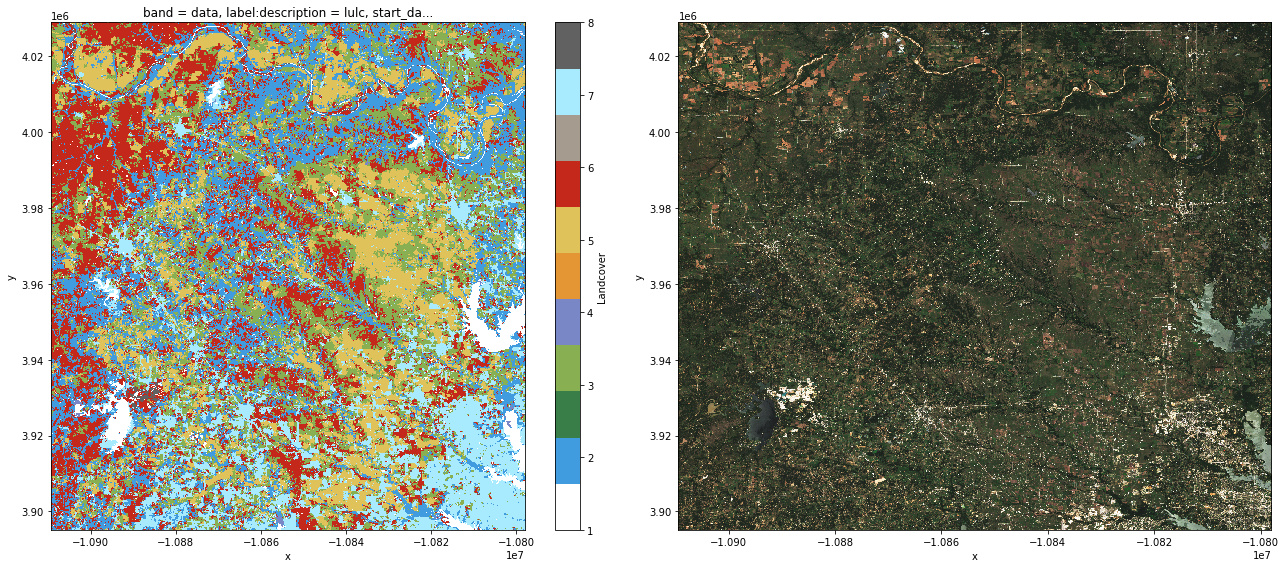

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 8))

landcover_data.plot.imshow(ax=ax1, cmap=landcover_cmap)
sentinel_img.plot.imshow(ax=ax2)
plt.tight_layout()

As a final bit of setup, compute NDVI for the Sentinel-2 scene. This will be your values raster when you compute zonal statistics later on.

In [10]:
red, nir = sentinel_data.sel(band=["red", "nir"])
ndvi = ((nir - red) / (nir + red)).persist()
ndvi

<xarray.DataArray 'stackstac-eb501f32fa93a0437a0d2d2bd6efece6' (y: 1338, x: 1115)>
dask.array<truediv, shape=(1338, 1115), dtype=float64, chunksize=(669, 1115), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * x                                        (x) float64 -1.091e+07 ... -1.08...
  * y                                        (y) float64 4.029e+06 ... 3.895e+06
    s2:product_type                          <U7 'S2MSI2A'
    constellation                            <U10 'Sentinel 2'
    s2:saturated_defective_pixel_percentage  float64 0.0
    s2:processing_baseline                   <U5 '02.12'
    ...                                       ...
    s2:datatake_type                         <U8 'INS-NOBS'
    sat:orbit_state                          <U10 'descending'
    instruments                              <U3 'msi'
    gsd                                      int64 10
    proj:shape                               object {10980}
    epsg                                     int64 3857

### Compute zonal statistics

Now that you have a zones raster (the landcover DataArray) and a values raster (NDVI derived from the Sentinel composite), you're ready to compute zonal stats.

Use [xrspatial.zonal.stats](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.stats.html) to compute a few summary statistics for each landcover class:

In [11]:
quantile_stats = (
    zonal_stats(
        zones=landcover_data,
        values=ndvi,
        stats_funcs=["mean", "max", "min", "count"],
    )
    .compute()
    .set_index("zone")
    .rename(landcover_labels)
)
quantile_stats.style.background_gradient()

,mean,max,min,count
zone,,,,
water,0.017884,0.846885,-0.443129,45139
trees,0.743280,0.900511,-0.277344,339387
grass,0.583749,0.877947,-0.140070,323999
flooded veg,0.547517,0.860692,-0.334288,1573
crops,0.510050,0.882642,-0.252886,241772
scrub,0.577787,0.879797,-0.375246,336952
built area,0.494027,0.878849,-0.388387,198272
bare,0.087579,0.704829,-0.375067,4776


Unsurprisingly, landcover classes like "trees" and "grass" have relatively high NDVI values. Classes like "water" and "bare" have relatively low values.

### Compute zonal cross-tabulation statistics

[xrspatial.zonal.crosstab](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.crosstab.html) calculates cross-tabulated areas between the zone raster and value raster. This function requires a 2D zone raster and a categorical value raster of 2D or 3D data. 

The `crosstab` function calculates different cross-tabulation statistics. It has an `agg` parameter to define which aggregation method to use. It returns a DataFrame where each row represents a zone from the zone raster, and each column represents a category from the value raster. 

This example uses the NASADEM elevation zones as its zone raster and the Esri Land Cover data as its categorical value raster. The resulting DataFrame will show the percentage of each land cover category for each of the five elevation zones.

In [12]:
nasadem_search = catalog.search(collections=["nasadem"], bbox=bounds)
nasadem_items = list(nasadem_search.get_items())

nasadem_data = (
    stackstac.stack(
        [pc.sign(item).to_dict() for item in nasadem_items],
        epsg=landcover_data.spec.epsg,
        resolution=landcover_data.resolution,
        bounds=landcover_data.spec.bounds,
        chunksize=2048,
    )
    .pipe(stackstac.mosaic)
    .squeeze()
    .persist()
).rename("Elevation (NASADEM)")
nasadem_data

<xarray.DataArray 'Elevation (NASADEM)' (y: 1338, x: 1115)>
dask.array<getitem, shape=(1338, 1115), dtype=float64, chunksize=(1338, 1115), chunktype=numpy.ndarray>
Coordinates:
    band        <U9 'elevation'
  * x           (x) float64 -1.091e+07 -1.091e+07 ... -1.08e+07 -1.08e+07
  * y           (y) float64 4.029e+06 4.029e+06 ... 3.895e+06 3.895e+06
    proj:epsg   int64 4326
    proj:shape  object {3601}
    title       <U9 'Elevation'
    epsg        int64 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-10909400, 3895100, -10797900,...
    crs:         epsg:3857
    transform:   | 100.00, 0.00,-10909400.00|\n| 0.00,-100.00, 4028900.00|\n|...
    resolution:  100

Next, discretize the NASADEM data into five zones:

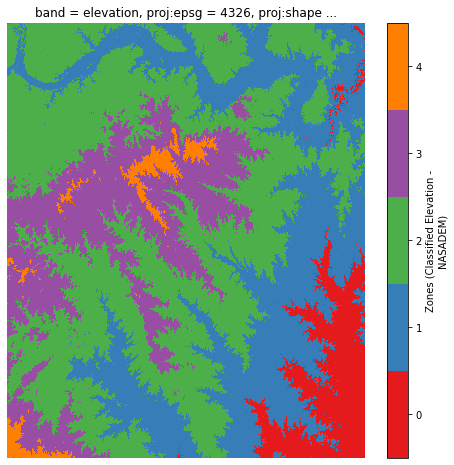

In [13]:
num_zones = 5
elevation_cmap = ListedColormap(plt.get_cmap("Set1").colors[:num_zones])

quantile_zones = equal_interval(
    nasadem_data, k=num_zones, name="Zones (Classified Elevation - NASADEM)"
)
fig, ax = plt.subplots(figsize=(8, 8))
img = quantile_zones.plot.imshow(cmap=elevation_cmap, ax=ax)
img.colorbar.set_ticks([0.4, 1.2, 2.0, 2.8, 3.6])
img.colorbar.set_ticklabels(range(5))

ax.set_axis_off()

Finally, calculate the cross-tabulation statistics and display a table demonstrating how the land cover categories are distributed over each of the five elevation zones. Set values for `zone_ids` and `cat_ids` to indicate the zones and the categories of interest. Use all the available zones and categories:

In [14]:
crosstab = (
    zonal_crosstab(
        zones=quantile_zones,
        values=landcover_data,
        agg="percentage",
    )
    .rename(columns=landcover_labels)
    .compute()
    .set_index("zone")
)

crosstab.style.background_gradient()

,water,trees,grass,flooded veg,crops,scrub,built area,bare
zone,,,,,,,,
0,19.270796,16.616853,10.577962,0.395211,7.421678,7.088585,38.439863,0.189053
1,2.027249,23.448931,22.147768,0.109607,20.129374,13.828654,17.774741,0.533675
2,2.075033,20.599665,23.654604,0.090979,16.611000,27.911911,8.759015,0.297792
3,0.596741,27.804037,21.278863,0.029319,14.013572,28.321761,7.864891,0.090816
4,0.216216,34.702703,19.106518,0.003180,6.206677,32.282989,7.033386,0.448331


### Next steps: analyze different datasets

The [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/catalog) includes petabytes of environmental monitoring data. All data sets are available in consistent, analysis-ready formats. You can access them through APIs as well as directly via [Azure Storage](https://docs.microsoft.com/en-us/azure/storage/).

Try using [xrspatial.zonal.stats](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.stats.html) and [xrspatial.zonal.crosstab](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.crosstab.html) with different datasets from the [Data Catalog](https://planetarycomputer.microsoft.com/catalog). For example, try using the land cover categories from the [Esri 10-Meter Land Cover](https://planetarycomputer.microsoft.com/dataset/io-lulc) dataset as zonal raster. Or try using the [Map of Biodiversity Importance (MoBI)](https://planetarycomputer.microsoft.com/dataset/mobi) dataset as a values raster.

There are also [other zonal functions in xarray spatial](https://xarray-spatial.org/reference/zonal.html) to use with your datasets.

Click on this link to go to the next notebook: [10 Census Data](10_Census_Data.ipynb)